In [1]:
#!pip install fbm

In [2]:
import numpy as np
from numpy import matlib

import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.ticker import PercentFormatter

from scipy import linalg

from scipy.stats import kurtosis, skew
from scipy.stats import t as t_dist

from scipy.optimize import minimize, Bounds

from fbm import fbm, fgn, times  # !pip install fbm if fbm is not already installed

In [3]:
# Formatting functions for tables
def to_scalar(x):
    """Ensure we always return a Python float scalar."""
    if isinstance(x, np.ndarray):
        return float(np.ravel(x)[0])
    return float(x)

def fmt_pct(x):
    """Format a scalar in [0,1] as percentage with 1 decimal."""
    return f"{to_scalar(x)*100:.1f}%"

def fmt_val(x, decimals=2):
    """Format as float with n decimals."""
    return f"{to_scalar(x):.{decimals}f}"

def fmt_ci(arr):
    """Convert into CI string [low, high] using first column."""
    arr = np.asarray(arr)
    return f"[{to_scalar(arr[2]):.1f}, {to_scalar(arr[3]):.1f}]"

In [4]:
# Function to return maximum drawdown

# Input: return time series
# Output: maximum drawdown

def Max_DD(ret_series):
    df = pd.concat([pd.DataFrame(np.zeros((1, ret_series.shape[1]))),pd.DataFrame(ret_series)], axis = 0) # Initialization
    wealth_index = (1 + df).cumprod() # Calculating price index
    previous_peaks = wealth_index.cummax() # Calculating previous peaks
    drawdown = (wealth_index - previous_peaks)/previous_peaks # Calculating relative losses
    return drawdown.min() # Returning maximum drawdown

In [5]:
nsims = 10000 # Number of MC simulations. We don't do robustness checks on this parameter.

# <font color='red'> 1. Numerical Analysis without Serial Correlation in Asset Returns </font>

In [6]:
# Generate the 3D cube with random numbers following a standard normal distribution
np.random.seed(123)  # set the seed for reproducibility
cube_snd = np.random.randn(1200, nsims, 100) # 1,200 months times 10,000 Monte Carlo simulations times 100 assets

In [7]:
# Function to calculate all the relevant analytics for the numerical analysis
# the rebalancing premium without serial correlation in asset returns


# Inputs: 
# mu: expected return vector
# sig: volatility vector
# corr: correlation matrix
# freq: rebalancing frequency in months
# dt: time step
# nsims: number of Monte Carlo simulations
# x: 3D-matrix of random increments 

# Outputs: analytics of the rebalanced and buy-and-hold portfolios (tab), 
# vector with outperformance proba RP and dSR (rstats) and vector of the growth rate differences(dgrowth)

def NumAnalysis(mu,sig,corr,w,freq,dt,steps,nsims,x):
    N = mu.shape[0] # number of assets
    S_0 = 100 * np.reshape(np.ones(N),(-1,1)) # initial (N*1) vector or prices at time t=0

    sigma = np.empty(shape=(N, N)) # covariance matrix
    
    for i in range(N):
        for j in range(N):
            sigma[i,j]=corr[i,j]*sig[i]*sig[j] # covariance matrix coefficients computation

    gstar=0.5*(sum(w*(sig*sig))-np.transpose(w)@ sigma @ w) # excess growth rate computation
    
    R = linalg.cholesky(corr) # Cholevsky factorisation: corr=R'*R where R is an upper triangular N*N matrix  
    S = np.empty(shape=(steps+1,nsims,N)) #initialisation of the steps+1 * nsims * N 3D-matrix of asset prices
 
    g = mu - sig*sig/2 #computation of the N*1 vector of expected growth rates
    
    # computation of the (steps+1)*N matrix of the stocks prices
    for i in range(nsims):
        inter=x[0:steps,i,0:N]; #extract from the 3D-matrix of random numbers x a steps*Nassets matrix of random numbers 
        ep = inter @ R; # correlated steps*N random numbers sequences: each asset has its pairwise-correlated random sequence of length steps
        S[:,i,:] = np.concatenate((np.reshape(np.ones(N),(1,-1)),np.cumprod(np.exp(np.matlib.repmat(np.transpose(g)*dt,steps,1)+ep@np.diagflat(sig)*np.sqrt(dt)), axis = 0)), axis = 0)@np.diagflat(S_0)# S(t+dt)=S(t)*exp(g*dt+sigma*sqrt(dt)*dz)
    
    r = np.empty(shape=(steps,nsims,N)) # preallocation of steps*nsims*N 3D-matrix of assets returns

    for i in range(N):
        r[:,:,i] = S[1:,:,i]/S[:-1,:,i]-1;  # steps*nsims*N 3D-matrix of the assets returns

        
    w_REB=np.empty(shape=(steps+1,nsims,N)) #wREB(t,i,k) is, for the simulation i, the weight of asset k at time t-1(used for the computation of the portfolios' return at time t
    wtemp=np.empty(shape=(N,1)) #%preallocation
     
    for i in range(nsims): #%computation of the steps*nsims*N 3D-vector of weights of the rebalanced portfolios
         wtemp[:,0]=w # N*1 vector of weights initialisation
    
         for t in range(steps+1):
            if (t-1)%freq==0: # if t corresponds to a rebalancing date    
                wtemp[:,0]=w # Set the weights to the computed/naive weighs. Be careful if the (optimised) weighting scheme is time varying, the code has to be improved. It works in the case of weights independent of time at the rebalancing dates.
                w_REB[t,i,:]=wtemp[:,0] #loop for REB portfolio weights computation
            else: #if t is not a rebalancing date then the weights are drifting
                wtemp[:,0]=wtemp[:,0]*(1+np.squeeze(r[t-1,i,:])) # We use the equality of assets'shares between two consecutive dates. Squeeze allows to extract a 1D vector or 2D matrix from a 3D matrix by deleting singleton dimensions 
                wtemp[:,0]=wtemp[:,0]/np.sum(wtemp[:,0]) # (see "La Gestion d'Actifs Quantitative, Roncalli", P48 for the idea of the proof)
                w_REB[t,i,:]=wtemp[:,0] #loop for REB portfolio weights computation

    r_REB=np.empty(shape=(steps,nsims)) #preallocation

    for i in range(nsims):
        for t in range(steps):
            r_REB[t,i]=np.sum(np.squeeze(w_REB[t,i,:])*np.squeeze(r[t,i,:])) #loop for REB portfolio returns computation
    
    P_REB= 100*np.concatenate((np.reshape(np.ones(nsims),(1,-1)),np.cumprod(1+r_REB,axis=0)), axis = 0)
  
    S_BH=np.empty(shape=(steps+1,nsims,N))  #%preallocation
    for i in range(N):
        S_BH[:,:,i]= w[i]*S[:,:,i] #loop for B&H portfolio wealth computation

 
    P_BH=np.sum(S_BH,2) # (steps+1)*nsims matrix of B&H portfolio wealth computation
    r_BH=P_BH[1:,:]/P_BH[:-1,:]-1 # steps*nsims matrix of B&H portfolio  return computation

    w_BH=np.empty(shape=(steps+1,nsims,N))  #%preallocation
    ENCt_BH=np.empty(shape=(steps+1,nsims))

    for i in range(nsims):
        for j in range(steps+1):
            w_BH[j,i,:]=np.squeeze(S_BH[j,i,:])/np.sum(np.squeeze(S_BH[j,i,:])) #loop for B&H portfolio weights computation
            ENCt_BH[j,i]=pow(1/np.linalg.norm(np.squeeze(w_BH[j,i,:])),2) *1/N

    # Risk, Performance and Diversification Statistics computation
    mu_REB=1/dt*np.mean(np.mean(r_REB,0))
    mu_BH=1/dt*np.mean(np.mean(r_BH,0))
    vol_REB=np.sqrt(1/dt)*np.mean(np.std(r_REB, axis = 0, ddof=1))
    vol_BH=np.sqrt(1/dt)*np.mean(np.std(r_BH, axis = 0, ddof=1))
    SR_REB=(mu_REB-0.02)/vol_REB
    SR_BH=(mu_BH-0.02)/vol_BH
    skewness_REB=np.mean(skew(r_REB, axis = 0, bias=False)) #data frequency has no impact
    skewness_BH=np.mean(skew(r_BH, axis = 0, bias=False))
    kurtosis_REB=np.mean(kurtosis(r_REB, fisher = False, axis = 0, bias = True))
    kurtosis_BH=np.mean(kurtosis(r_BH, fisher = False, axis = 0, bias = True))
    MDDown_REB=-np.mean(Max_DD(r_REB))
    MDDown_BH=-np.mean(Max_DD(r_BH))
    var1_REB=-np.mean(np.percentile(r_REB, 0.01 ,axis=0))
    var1_BH=-np.mean(np.percentile(r_BH,0.01 ,axis=0))
    ENC_BH=np.mean(np.mean(ENCt_BH,0))

#Rebalancing Statistics computation
    Ratio=P_REB/P_BH #Wealth ratio between REB and B&H
    P=np.empty(shape=(steps+1,1))  #preallocation
    for i in range(steps+1):
        P[i]=np.sum(Ratio[i,:]>1)/Ratio[i,:].shape[0] #loop for outperformance probability computation. No problem with rebalancing frequency (I thought about that!) 


    dgrowthnonan=np.log(Ratio)
    dgrowth=1/(steps*dt)*dgrowthnonan[steps,:]
    dwealth=P_REB[steps,:]-P_BH[steps,:]
    RP=np.mean(dgrowth)

    dSR=SR_REB-SR_BH


#Turnover computation
    wtemp=np.empty(shape=(N,1)) #preallocation
    w_minus_REB=np.empty(shape=(steps,nsims,N)) #preallocation
    deltaw=np.empty(shape=(steps,nsims)) #preallocation
    for i in range(nsims):
        for t in range(freq-1,steps,freq): #consider each date before the month of a rebalancing date
            wtemp=w_REB[t,i,:]*(1+r[t,i,:])
            w_minus_REB[t,i,:]=wtemp/np.sum(wtemp) #Watch that w_REB(t+1) corresponds to w and it's ok :-).
            deltaw[t,i]=np.sum(np.abs(np.squeeze(w_minus_REB[t,i,:])-w))

    nbreb=np.sum(~np.isnan(deltaw[:,1])) #number of rebalancing
    Turnover_REB=1/freq*12*0.5*np.nanmean(np.nanmean(deltaw,0),0)
    
    tab=np.empty(shape=(8,2))
    
    tab[0,0]=mu_REB
    tab[1,0]=vol_REB
    tab[2,0]=SR_REB
    tab[3,0]=skewness_REB
    tab[4,0]=kurtosis_REB
    tab[5,0]=MDDown_REB
    tab[6,0]=var1_REB
    tab[7,0]=Turnover_REB
 
    tab[0,1]=mu_BH
    tab[1,1]=vol_BH
    tab[2,1]=SR_BH
    tab[3,1]=skewness_BH
    tab[4,1]=kurtosis_BH
    tab[5,1]=MDDown_BH
    tab[6,1]=var1_BH
    tab[7,1]=0


    rstats=np.empty(shape=(10,1))
    
    rstats[0]=P[steps]
    rstats[1]=RP * 10000. # in bps
    rstats[2]=(RP - t_dist.ppf(0.975, nsims-1)*np.std(dgrowth,ddof = 1)/np.sqrt(nsims-1))*10000 # in bps
    rstats[3]=(RP + t_dist.ppf(0.975, nsims-1)*np.std(dgrowth,ddof = 1)/np.sqrt(nsims-1)) *10000 # in bps
    rstats[4]=(gstar)*10000
    rstats[5]=(RP-gstar)*10000
    rstats[6]=np.mean(dgrowth[dgrowth>0])*10000
    rstats[7]=np.mean(dgrowth[dgrowth<0])*10000
    rstats[8]=dSR
    rstats[9]=np.std(dgrowth)*10000
    
    return tab, rstats, dgrowth, dwealth

## <font color='green'> 1.1. Base Case Scenario </font>

In [8]:
# Define the rebalancing frequency in months (freq), the observation frequency (dt), the time horizon (steps),
# the number of MC simulations (nsims) and the number of risky assets (N)
freq = 1 
dt = 1 / 12
steps = 60
N = 30
x = cube_snd

# Define the initial portfolio weights
w = np.full(N, 1/N)

# Define the mean (mu) and standard deviation (sigma) arrays
mu = np.full(N, 0.10)
sig = np.full(N, 0.20)

# Correlation matrix as an identity matrix
corr = np.identity(N)
for i in range(N):
    for j in range(N):
        if i != j: 
            corr[i, j] = 0 # Set off-diagonal elements to 0

In [9]:
base_case = NumAnalysis(mu,sig,corr,w,freq,dt,steps,nsims,cube_snd)

### <font color='dodgerblue'> 1.1.1. Table 1 </font>

In [10]:
# Statistics for a 5-year time horizon
# It corresponds to the first 8 rows of Table 1.
base_case[0]

array([[0.10052301, 0.10054567],
       [0.03673096, 0.03852657],
       [2.19223785, 2.09065237],
       [0.03190573, 0.03590415],
       [2.90174714, 2.91313561],
       [0.02085955, 0.02285842],
       [0.01603748, 0.01725234],
       [0.27172179, 0.        ]])

In [11]:
# Statistics for a 5-year time horizon
# It corresponds to the last 10 rows of Table 1.
base_case[1]

array([[ 5.39100000e-01],
       [ 4.46310528e-01],
       [-5.61665208e-01],
       [ 1.45428626e+00],
       [ 1.93333333e+02],
       [-1.92887023e+02],
       [ 3.83669022e+01],
       [-4.39081937e+01],
       [ 1.01585480e-01],
       [ 5.14169110e+01]])

Now, we are going to concatenate these two array to obtain Table 1.

In [12]:
# Arrays
part1 = base_case[0]   # First set of statistics from expected return to turnover for the rebalanced and b&h portfolios
part2 = base_case[1]   # Second set of statistics related to the rebalancing premium, outperformance proba and difference in SR

# Labels
metrics_top = [
    "Expected return",
    "Annualised volatility",
    "Sharpe Ratio",
    "Skewness",
    "Kurtosis",
    "Maximum Drawdown",
    "Monthly VaR 1%",
    "Turnover"
]

metrics_bottom = [
    "Outperformance probability",
    "Rebalancing premium (bps)",
    "Rebalancing premium CI95% (bps)",
    "Excess growth rate g* (bps)",
    "Dispersion term (bps)",
    "Conditional (>0) Rebalancing premium (bps)",
    "Conditional (<0) Rebalancing premium (bps)",
    "Difference in Sharpe ratios",
    "Std. dev. of growth rate differences (bps)"
]

# Top part (8 rows, two portfolios) 
df_top = pd.DataFrame({
    "Metric": metrics_top,
    "Rebalanced Portfolio": [
        fmt_pct(part1[i,0]) if i in [0,1,5,6,7] else fmt_val(part1[i,0], 2) for i in range(8)
    ],
    "Buy-and-Hold Portfolio": [
        fmt_pct(part1[i,1]) if i in [0,1,5,6,7] else fmt_val(part1[i,1], 2) for i in range(8)
    ]
})

# Bottom part (9 rows)
df_bottom = pd.DataFrame({
    "Metric": metrics_bottom,
    "Rebalanced Portfolio": [
        fmt_pct(part2[0,0]),   # outperformance probability
        fmt_val(part2[1,0], 1),# rebalancing premium
        fmt_ci(part2[:,0]),         # CI
        fmt_val(part2[4,0], 1),
        fmt_val(part2[5,0], 1),
        fmt_val(part2[6,0], 1),
        fmt_val(part2[7,0], 1),
        fmt_val(part2[8,0], 2),
        fmt_val(part2[9,0], 1)
    ],
    "Buy-and-Hold Portfolio": ["" for _ in metrics_bottom]
})

# Merge
df = pd.concat([df_top, df_bottom], ignore_index=True)

# Display 
display(df)

,Metric,Rebalanced Portfolio,Buy-and-Hold Portfolio
0,Expected return,10.1%,10.1%
1,Annualised volatility,3.7%,3.9%
2,Sharpe Ratio,2.19,2.09
3,Skewness,0.03,0.04
4,Kurtosis,2.90,2.91
5,Maximum Drawdown,2.1%,2.3%
6,Monthly VaR 1%,1.6%,1.7%
7,Turnover,27.2%,0.0%
8,Outperformance probability,53.9%,
9,Rebalancing premium (bps),0.4,


### <font color='dodgerblue'> 1.1.2. Figure 1 </font>

In [13]:
# Differences in terminal wealth (cf. Figure 1)
base_case[3]

array([-6.62823558,  3.23847607,  3.29614329, ...,  3.21020709,
        2.79630462, -1.00610261], shape=(10000,))

The chart and the statistics table below correspond to those shown in Figure 1. However, the chart in the paper was produced using Excel.

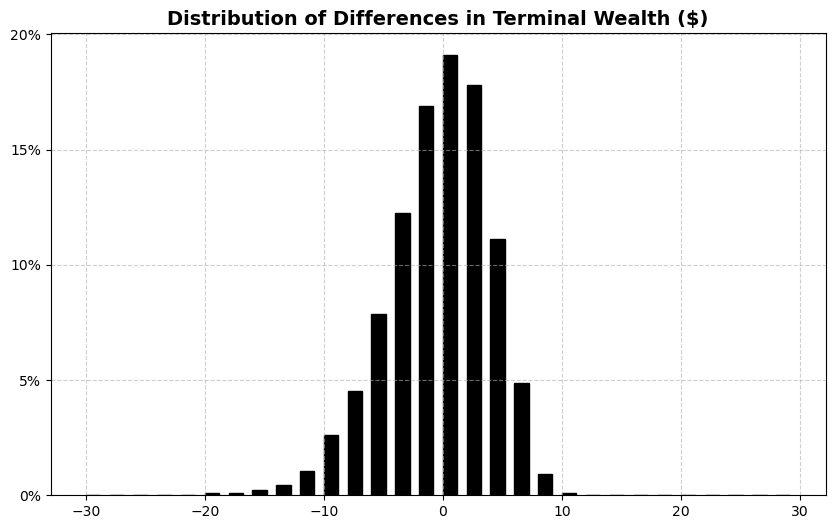

In [14]:
data = base_case[3]

# Define bins from -30 to 30 in steps of 2
bins = np.arange(-30, 32, 2)

# Raw counts
counts, edges = np.histogram(data, bins=bins)

# Convert to relative frequencies 
rel_freq = counts / counts.sum()



plt.figure(figsize=(10,6))
plt.bar(edges[:-1], rel_freq, width=1.2, color="black", edgecolor="black", align="edge")

plt.title("Distribution of Differences in Terminal Wealth ($)", fontsize=14, fontweight="bold")

# Format y-axis as integer percentages, step 5%
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0, decimals=0))
plt.gca().yaxis.set_major_locator(mtick.MultipleLocator(0.05))

plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

In [15]:
# Compute stats
stats = {
    "maximum": np.max(data),
    "minimum": np.min(data),
    "average": np.mean(data),
    "median": np.median(data),
    "std deviation": np.std(data, ddof=1),
    "skewness": skew(data),
    "kurtosis": kurtosis(data, fisher=True)  # excess kurtosis
}

# Apply custom rounding
formatted_stats = {
    "maximum":  f"{stats['maximum']:.1f}",
    "minimum":  f"{stats['minimum']:.1f}",
    "average":  f"{stats['average']:.1f}",
    "median":  f"{stats['median']:.1f}",
    "std deviation":  f"{stats['std deviation']:.1f}",
    "skewness": f"{stats['skewness']:.2f}",
    "kurtosis": f"{stats['kurtosis']:.2f}"
}

# Display as a DataFrame with clean formatting
stats_df = pd.DataFrame.from_dict(formatted_stats, orient="index", columns=["Value"])
display(stats_df)

,Value
maximum,10.6
minimum,-27.4
average,-0.0
median,0.4
std deviation,4.3
skewness,-0.65
kurtosis,0.81


## <font color='green'> 1.2. Robustness Check w.r.t the initial weighting scheme </font>

In [16]:
# Function to calculate the maxgstar portfolio
def maxgstar(C):
    N, _ = C.shape
    Aeq = np.ones(N)
    beq = 1
    lb = np.zeros(N)
    x0 = np.ones(N) / N

    def obj(w):
        return -0.5 * (w.T @ ((np.eye(N) * C) @ np.ones(N)) - w.T @ C @ w)

    def budget(w):
        return np.sum(w) - 1.
    
    cons = [{'type': 'eq', 'fun': budget}]
    
    w0 = np.ones(N) / N  # Equally weighted portfolio
    
    bnds = [(1/(3*N), None)] * N  # Set lower bound constraints on the variables
    
    m = minimize(obj, w0, constraints=cons, bounds=bnds, tol = 10**-15) # tol is the tolerance for the stopping criteria. It tells the optimizer 
                                                                       # to stop searching for a minimum once some tolerance is achieved, 
                                                                       # i.e. once the objective function is 'close enough' to zero.
    
    return m.x

In [17]:
# Function to calculate the erc portfolio weights
def erc(Sigma):
    n = Sigma.shape[0]  # Number of constituents
    
    def obj(w):  # Objective function: we want to minimize the sum of (w_i*[Sigma w]_i - sigma_P^2/n)^2
        y = w * (Sigma @ w)
        return np.linalg.norm(y - sum(y) / n) 
    
    def budget(w):
        return np.sum(w) - 1.
    
    cons = [{'type': 'eq', 'fun': budget}]
    
    w0 = np.ones(n) / n  # Equally weighted portfolio
    
    bnds = Bounds([0] * n) # Set bound constraints on the variables via Bounds from scipy.optimize. 
                           # It is equivalent to write bnds= [(0 , _) for i in range(0,n)]
    
    m = minimize(obj, w0, constraints=cons, bounds=bnds, tol = 10**-15) # tol is the tolerance for the stopping criteria. It tells the optimizer 
                                                                       # to stop searching for a minimum once some tolerance is achieved, 
                                                                       # i.e. once the objective function is 'close enough' to zero.
    
    return m.x

In [18]:
# Define the rebalancing frequency in months (freq), the observation frequency (dt), the time horizon (steps),
# the number of MC simulations (nsims) and the number of risky assets (N)
freq = 1 
dt = 1 / 12
steps = 60
N = 30
x = cube_snd

# Define the mean (mu) and standard deviation (sigma) arrays
sig = np.concatenate([np.full(10, 0.15), np.full(10, 0.3), np.full(10, 0.45)])
mu = 0.02 + 0.4*sig

# Correlation matrix as an identity matrix
corr = np.identity(N)
for i in range(N):
    for j in range(N):
        if i != j: 
            corr[i, j] = 0.2 # Set off-diagonal elements to 0.2
            
# Define the initial portfolio weights
w_ew = np.full(N, 1/N) # Equally-weighted portfolio
w_erc = erc(sig.T*corr*sig) # Equal risk contribution portfolio
w_maxgstar = maxgstar(sig.T*corr*sig) # Max g* portfolio

In [19]:
rc_1_ew = NumAnalysis(mu,sig,corr,w_ew,freq,dt,steps,nsims,cube_snd)
rc_1_erc = NumAnalysis(mu,sig,corr,w_erc,freq,dt,steps,nsims,cube_snd)
rc_1_maxgstar = NumAnalysis(mu,sig,corr,w_maxgstar,freq,dt,steps,nsims,cube_snd)

### <font color='dodgerblue'> 1.2.1. Table 2 </font>

`rc_1_ew`, `rc_1_erc` and `rc_1maxgstar` are tuple that contain 4 arrays.
We need the first two elements of each tuple to built Table 2.

In [20]:
# First block (8 rows) 
metrics1 = [
    "Expected return",
    "Volatility",
    "Sharpe ratio",
    "Skewness",
    "Kurtosis",
    "Maximum drawdown",
    "Monthly VaR 1%",
    "Turnover"
]

# Take first element of each tuple of 4 arrays, then take the first column of the array.
# This first column represents the first set of statistics related to the rebalanced portfolio.
ew1   = rc_1_ew[0][:,0]
erc1  = rc_1_erc[0][:,0]
maxg1 = rc_1_maxgstar[0][:,0]

df1 = pd.DataFrame({
    "Metric": metrics1,
    "Equally Weighted": [
        fmt_pct(ew1[0]),
        fmt_pct(ew1[1]),
        fmt_val(ew1[2], 2),
        fmt_val(ew1[3], 2),
        fmt_val(ew1[4], 2),
        fmt_pct(ew1[5]),
        fmt_pct(ew1[6]),
        fmt_pct(ew1[7])
    ],
    "Equal Risk": [
        fmt_pct(erc1[0]),
        fmt_pct(erc1[1]),
        fmt_val(erc1[2], 2),
        fmt_val(erc1[3], 2),
        fmt_val(erc1[4], 2),
        fmt_pct(erc1[5]),
        fmt_pct(erc1[6]),
        fmt_pct(erc1[7])
    ],
    "Max g*": [
        fmt_pct(maxg1[0]),
        fmt_pct(maxg1[1]),
        fmt_val(maxg1[2], 2),
        fmt_val(maxg1[3], 2),
        fmt_val(maxg1[4], 2),
        fmt_pct(maxg1[5]),
        fmt_pct(maxg1[6]),
        fmt_pct(maxg1[7])
    ]
})

# Second block (9 rows) 
metrics2 = [
    "Outperformance probability",
    "Rebalancing premium (bps)",
    "Rebalancing premium CI95% (bps)",
    "Excess growth rate g* (bps)",
    "Dispersion term (bps)",
    "Conditional (>0) Rebalancing premium (bps)",
    "Conditional (<0) Rebalancing premium (bps)",
    "Difference in Sharpe ratios",
    "Std. dev. of growth rate differences (bps)"
]

# Take second element of tuple of 4 arrays, then take the first column of the array
# This first column represents the second set of statistics related to the rebalanced portfolio
ew2   = rc_1_ew[1][:,0]
erc2  = rc_1_erc[1][:,0]
maxg2 = rc_1_maxgstar[1][:,0]

df2 = pd.DataFrame({
    "Metric": metrics2,
    "Equally Weighted": [
        fmt_pct(ew2[0]),
        fmt_val(ew2[1], 1),
        fmt_ci(ew2),
        fmt_val(ew2[4], 1),
        fmt_val(ew2[5], 1),
        fmt_val(ew2[6], 1),
        fmt_val(ew2[7], 1),
        fmt_val(ew2[8], 2),
        fmt_val(ew2[9], 1)
    ],
    "Equal Risk": [
        fmt_pct(erc2[0]),
        fmt_val(erc2[1], 1),
        fmt_ci(erc2),
        fmt_val(erc2[4], 1),
        fmt_val(erc2[5], 1),
        fmt_val(erc2[6], 1),
        fmt_val(erc2[7], 1),
        fmt_val(erc2[8], 2),
        fmt_val(erc2[9], 1)
    ],
    "Max g*": [
        fmt_pct(maxg2[0]),
        fmt_val(maxg2[1], 1),
        fmt_ci(maxg2),
        fmt_val(maxg2[4], 1),
        fmt_val(maxg2[5], 1),
        fmt_val(maxg2[6], 1),
        fmt_val(maxg2[7], 1),
        fmt_val(maxg2[8], 2),
        fmt_val(maxg2[9], 1)
    ]
})

# Final concatenation to obtain Table 2
df_final = pd.concat([df1, df2], ignore_index=True)
display(df_final)

,Metric,Equally Weighted,Equal Risk,Max g*
0,Expected return,14.2%,13.8%,18.3%
1,Volatility,14.6%,14.1%,20.8%
2,Sharpe ratio,0.83,0.84,0.78
3,Skewness,0.14,0.14,0.18
4,Kurtosis,2.93,2.93,2.95
5,Maximum drawdown,16.7%,16.1%,24.1%
6,Monthly VaR 1%,8.1%,7.9%,11.6%
7,Turnover,37.7%,36.6%,48.7%
8,Outperformance probability,50.3%,49.6%,58.0%
9,Rebalancing premium (bps),-30.7,-32.4,4.1


## <font color='green'> 1.3. Two-dimensional robustness check with regard to volatility and pairwise correlation </font>

In [21]:
# Define parameters
N = 30
mu = np.full(N, 0.10)
sig_values = [0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50]
corr_values = [0.00, 0.20, 0.40, 0.60, 0.80]
w = np.ones(N) / N
freq = 1
dt = 1 / 12
steps = 60

# Initialize arrays to store results
prob = np.zeros((len(sig_values), len(corr_values)))
reb = np.zeros((len(sig_values), len(corr_values)))
dSR = np.zeros((len(sig_values), len(corr_values)))

# Loop for robustness checks
for i, sig_val in enumerate(sig_values):
    for j, corr_val in enumerate(corr_values):
        corr = (1 - corr_val) * np.eye(N) + corr_val * np.ones((N, N))
        _, i2, _, _ = NumAnalysis(mu, sig_val* np.ones(N), corr, w, freq, dt, steps, nsims, cube_snd)
        prob[i, j] = i2[0][0]
        reb[i, j] = i2[1][0]
        dSR[i, j] = i2[8][0]

In [22]:
# Outperformance probability for various levels of volatility and pairwise correlation
prob

array([[0.5324, 0.5339, 0.5327, 0.5314, 0.5334],
       [0.5344, 0.536 , 0.5335, 0.533 , 0.5341],
       [0.5391, 0.5413, 0.5373, 0.5341, 0.5335],
       [0.5454, 0.5443, 0.5416, 0.5374, 0.5342],
       [0.5506, 0.5521, 0.5468, 0.541 , 0.5355],
       [0.56  , 0.5581, 0.5529, 0.545 , 0.5375],
       [0.5685, 0.5658, 0.5588, 0.5498, 0.5403],
       [0.5788, 0.5744, 0.5642, 0.5554, 0.5428],
       [0.5893, 0.582 , 0.5712, 0.5587, 0.5453]])

In [23]:
# Rebalancing premium for various levels of volatility and pairwise correlation
reb

array([[-8.80649344e-03, -9.66445369e-03, -1.21600637e-02,
        -1.13064616e-02, -7.34270063e-03],
       [ 8.92986844e-02,  4.65419909e-02,  9.88296262e-03,
        -9.54517644e-03, -1.28774147e-02],
       [ 4.46310528e-01,  2.61993409e-01,  1.15386334e-01,
         2.49491901e-02, -1.30897121e-02],
       [ 1.30953662e+00,  7.88389201e-01,  3.86124951e-01,
         1.26893806e-01,  1.93905520e-04],
       [ 3.03172033e+00,  1.83922975e+00,  9.35409230e-01,
         3.43575273e-01,  3.79294599e-02],
       [ 6.09228956e+00,  3.70183354e+00,  1.91345229e+00,
         7.36489142e-01,  1.14061798e-01],
       [ 1.11159274e+01,  6.74946428e+00,  3.51335546e+00,
         1.38328195e+00,  2.45776433e-01],
       [ 1.88823914e+01,  1.14508970e+01,  5.97697155e+00,
         2.37989576e+00,  4.53794528e-01],
       [ 3.03227680e+01,  1.83745986e+01,  9.59964201e+00,
         3.84275310e+00,  7.62706375e-01]])

In [24]:
# Difference in SR for various levels of volatility and pairwise correlation
dSR

array([[5.18706571e-02, 1.87416978e-03, 4.04455494e-04, 9.23976810e-05,
        9.55006672e-06],
       [7.70822659e-02, 2.81369216e-03, 5.99232546e-04, 1.34019954e-04,
        1.29955761e-05],
       [1.01585480e-01, 3.79017544e-03, 7.99778692e-04, 1.75902710e-04,
        1.61377157e-05],
       [1.25034358e-01, 4.81419647e-03, 1.00826495e-03, 2.18434179e-04,
        1.90122739e-05],
       [1.47017973e-01, 5.89396316e-03, 1.22660157e-03, 2.61950781e-04,
        2.16470467e-05],
       [1.67093495e-01, 7.03411640e-03, 1.45634420e-03, 3.06730934e-04,
        2.40614513e-05],
       [1.84849070e-01, 8.23448838e-03, 1.69858089e-03, 3.52989298e-04,
        2.62663124e-05],
       [1.99974659e-01, 9.48920992e-03, 1.95381202e-03, 4.00871607e-04,
        2.82638581e-05],
       [2.12312119e-01, 1.07865436e-02, 2.22184503e-03, 4.50450082e-04,
        3.00479557e-05]])

### <font color='dodgerblue'> 1.3.1. Figure 2 </font>

We reproduce below the three charts of Figure 2. The versions presented in the paper were originally generated with Excel.

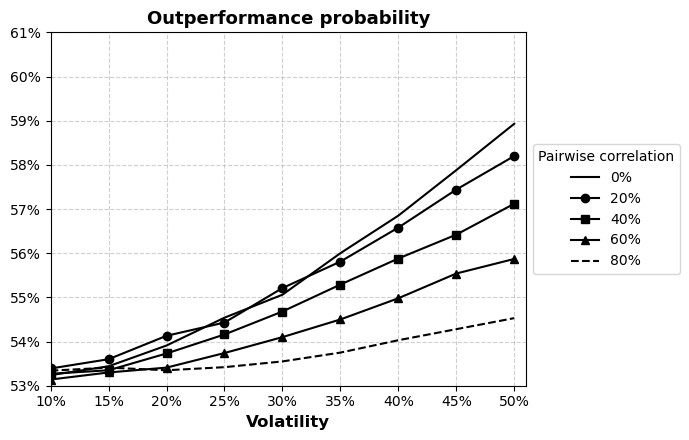

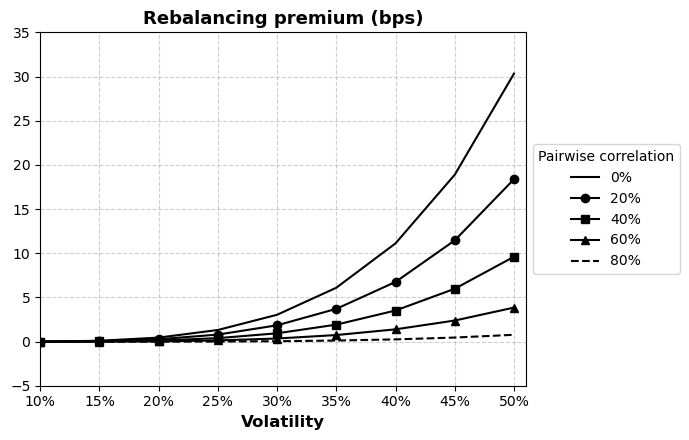

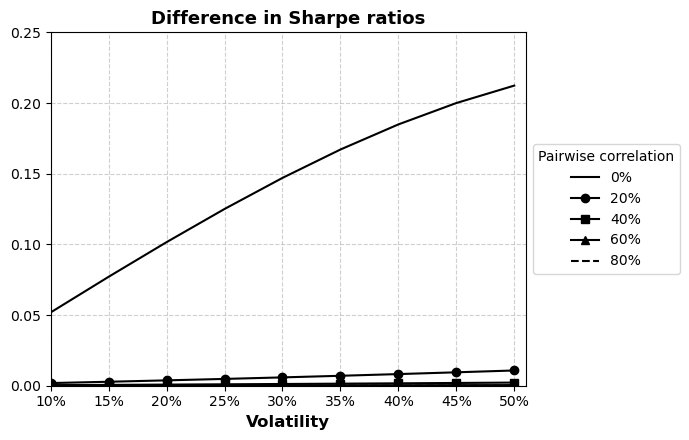

In [25]:
# Convert to numpy arrays
sig_values = np.array(sig_values)
corr_values = np.array(corr_values)

# Define style mapping for correlation levels
style_map = {
    0.00: {"linestyle": "-", "marker": None},
    0.20: {"linestyle": "-", "marker": "o"},  # round
    0.40: {"linestyle": "-", "marker": "s"},  # square
    0.60: {"linestyle": "-", "marker": "^"},  # triangle up
    0.80: {"linestyle": "--", "marker": None} # dashed, no marker
}

# 1. Outperformance probability
plt.figure(figsize=(7,4.5))
for j, c in enumerate(corr_values):
    style = style_map[c]
    plt.plot(sig_values*100, prob[:, j]*100,
             label=f"{int(c*100)}%", 
             color="black", linestyle=style["linestyle"], 
             marker=style["marker"], markersize=6, markevery=1)

plt.xlabel("Volatility", fontsize=12, fontweight="bold")
plt.title("Outperformance probability", fontsize=13, fontweight="bold")
plt.legend(title="Pairwise correlation", loc="center left", bbox_to_anchor=(1, 0.5))
plt.grid(True, linestyle="--", alpha=0.6)
plt.gca().xaxis.set_major_formatter(PercentFormatter(xmax=100, decimals=0))
plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=100, decimals=0))
plt.xlim(10, 51)
plt.ylim(53, 61)
plt.xticks(np.arange(10, 55, 5))
plt.yticks(np.arange(53, 62, 1))
plt.tight_layout()
plt.show()

# 2. Rebalancing premium (bps) 
plt.figure(figsize=(7,4.5))
for j, c in enumerate(corr_values):
    style = style_map[c]
    plt.plot(sig_values*100, reb[:, j],   # convert to bps
             label=f"{int(c*100)}%", 
             color="black", linestyle=style["linestyle"], 
             marker=style["marker"], markersize=6, markevery=1)

plt.xlabel("Volatility", fontsize=12, fontweight="bold")
plt.title("Rebalancing premium (bps)", fontsize=13, fontweight="bold")
plt.legend(title="Pairwise correlation", loc="center left", bbox_to_anchor=(1, 0.5))
plt.grid(True, linestyle="--", alpha=0.6)
plt.gca().xaxis.set_major_formatter(PercentFormatter(xmax=100, decimals=0))
plt.xlim(10, 51)
plt.ylim(-5, 35)
plt.xticks(np.arange(10, 55, 5))
plt.yticks(np.arange(-5, 40, 5))
plt.tight_layout()
plt.show()

# 3. Difference in Sharpe ratios
plt.figure(figsize=(7,4.5))
for j, c in enumerate(corr_values):
    style = style_map[c]
    plt.plot(sig_values*100, dSR[:, j], 
             label=f"{int(c*100)}%", 
             color="black", linestyle=style["linestyle"], 
             marker=style["marker"], markersize=6, markevery=1)

plt.xlabel("Volatility", fontsize=12, fontweight="bold")
plt.title("Difference in Sharpe ratios", fontsize=13, fontweight="bold")
plt.legend(title="Pairwise correlation", loc="center left", bbox_to_anchor=(1, 0.5))
plt.grid(True, linestyle="--", alpha=0.6)
plt.gca().xaxis.set_major_formatter(PercentFormatter(xmax=100, decimals=0))
plt.xlim(10, 51)
plt.ylim(0.00, 0.25)  
plt.xticks(np.arange(10, 55, 5))
plt.yticks(np.arange(0.00, 0.30, 0.05))
plt.tight_layout()
plt.show()

## <font color='green'>  1.4. Two-dimensional robustness check with regard to volatility and time horizon </font>

In [26]:
# Define parameters
N = 30
mu = np.full(N, 0.10)
sig_values = [0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50]
corr = np.identity(N)
w = np.ones(N) / N
freq = 1
dt = 1 / 12
step_values = [60, 120, 240, 600, 1200]

# Initialize arrays to store results
prob = np.zeros((len(sig_values), len(step_values)))
reb = np.zeros((len(sig_values), len(step_values)))
dSR = np.zeros((len(sig_values), len(step_values)))

# Loop for robustness checks
for i, sig_val in enumerate(sig_values):
    for j, step_val in enumerate(step_values):
        _, i2, _, _ = NumAnalysis(mu, sig_val* np.ones(N), corr, w, freq, dt, step_val, nsims, cube_snd)
        prob[i, j] = i2[0][0]
        reb[i, j] = i2[1][0]
        dSR[i, j] = i2[8][0]

In [27]:
# Outperformance probability for various levels of volatility and time horizon
prob

array([[0.5324, 0.5384, 0.5436, 0.5599, 0.5825],
       [0.5344, 0.5433, 0.5568, 0.5887, 0.637 ],
       [0.5391, 0.5526, 0.571 , 0.6255, 0.6995],
       [0.5454, 0.564 , 0.5898, 0.6722, 0.768 ],
       [0.5506, 0.5763, 0.6163, 0.7187, 0.8313],
       [0.56  , 0.5913, 0.6415, 0.7641, 0.8835],
       [0.5685, 0.6073, 0.6683, 0.8104, 0.9283],
       [0.5788, 0.6243, 0.698 , 0.8525, 0.9589],
       [0.5893, 0.645 , 0.7289, 0.8881, 0.9772]])

In [28]:
# Rebalancing premium for various levels of volatility and time horizon
reb

array([[-8.80649344e-03, -1.02500837e-01,  2.28864595e-02,
         4.68841562e-01,  1.03457795e+00],
       [ 8.92986844e-02, -5.79394451e-03,  5.62548050e-01,
         2.55651213e+00,  5.99112550e+00],
       [ 4.46310528e-01,  6.11088327e-01,  2.46308999e+00,
         8.97607477e+00,  2.00100378e+01],
       [ 1.30953662e+00,  2.33723619e+00,  7.16533614e+00,
         2.34614845e+01,  4.80978897e+01],
       [ 3.03172033e+00,  6.04782910e+00,  1.66861161e+01,
         4.98428484e+01,  9.38812354e+01],
       [ 6.09228956e+00,  1.29320310e+01,  3.34312325e+01,
         9.13503377e+01,  1.59661446e+02],
       [ 1.11159274e+01,  2.44667096e+01,  5.99161176e+01,
         1.50431992e+02,  2.46846222e+02],
       [ 1.88823914e+01,  4.23373400e+01,  9.85259544e+01,
         2.28850590e+02,  3.56301818e+02],
       [ 3.03227680e+01,  6.83320822e+01,  1.51374182e+02,
         3.27851012e+02,  4.88573150e+02]])

In [29]:
# Difference in SR for various levels of volatility and time horizon
dSR

array([[0.05187066, 0.10307241, 0.20493583, 0.49560825, 0.90828204],
       [0.07708227, 0.1520993 , 0.29762198, 0.66703275, 1.07484214],
       [0.10158548, 0.19792116, 0.3752378 , 0.7521318 , 1.06827713],
       [0.12503436, 0.23885916, 0.43204335, 0.76801757, 0.99323429],
       [0.14701797, 0.27324131, 0.46661835, 0.7448883 , 0.90378158],
       [0.1670935 , 0.29996787, 0.48195739, 0.70476171, 0.81901738],
       [0.18484907, 0.31884958, 0.48306142, 0.65956574, 0.74402445],
       [0.19997466, 0.33052657, 0.47478739, 0.61489002, 0.67911471],
       [0.21231212, 0.33613615, 0.46091795, 0.573055  , 0.62318871]])

### <font color='dodgerblue'> 1.4.1. Figure 3 </font>

We reproduce below the three charts of Figure 3. The versions presented in the paper were originally generated with Excel.

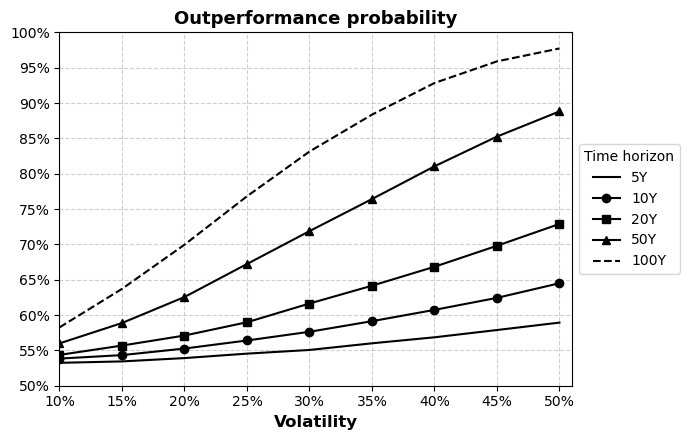

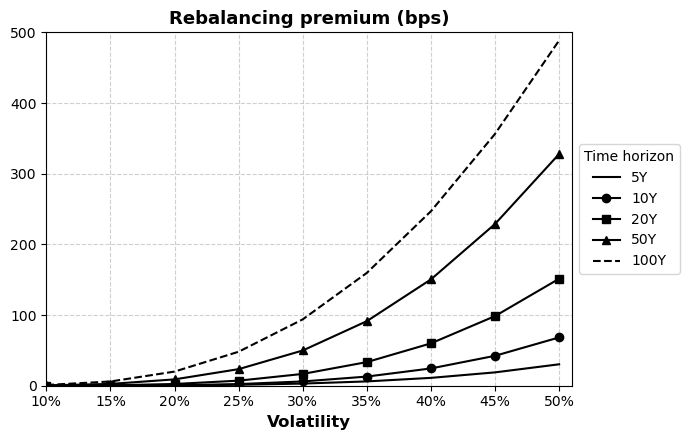

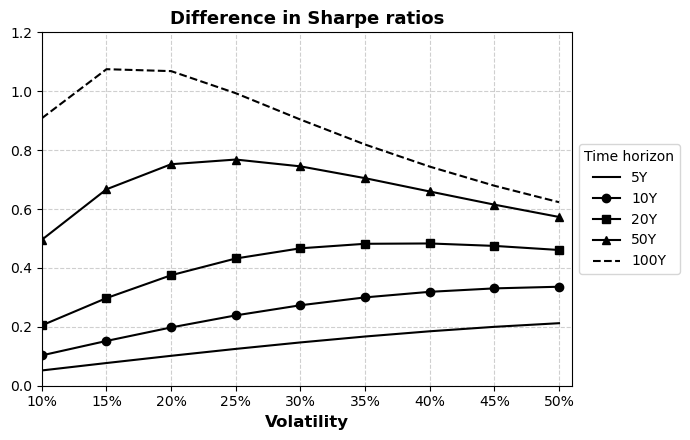

In [30]:
# Convert to numpy arrays
sig_values = np.array(sig_values)
step_values = np.array(step_values)

# Define style mapping for horizons
style_map = {
    60:   {"linestyle": "-", "marker": None},
    120:  {"linestyle": "-", "marker": "o"},  # round
    240:  {"linestyle": "-", "marker": "s"},  # square
    600:  {"linestyle": "-", "marker": "^"},  # triangle
    1200: {"linestyle": "--", "marker": None} # dashed, no marker
}

# Define label mapping in years
label_map = {
    60: "5Y",
    120: "10Y",
    240: "20Y",
    600: "50Y",
    1200: "100Y"
}

# 1. Outperformance probability
plt.figure(figsize=(7,4.5))
for j, step in enumerate(step_values):
    style = style_map[step]
    plt.plot(sig_values*100, prob[:, j]*100,
             label=label_map[step], 
             color="black", linestyle=style["linestyle"], 
             marker=style["marker"], markersize=6, markevery=1)

plt.xlabel("Volatility", fontsize=12, fontweight="bold")
plt.title("Outperformance probability", fontsize=13, fontweight="bold")
plt.legend(title="Time horizon", loc="center left", bbox_to_anchor=(1, 0.5))
plt.grid(True, linestyle="--", alpha=0.6)
plt.gca().xaxis.set_major_formatter(PercentFormatter(xmax=100, decimals=0))
plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=100, decimals=0))
plt.xlim(10, 51)
plt.ylim(50, 100)
plt.xticks(np.arange(10, 55, 5))
plt.yticks(np.arange(50, 101, 5))
plt.tight_layout()
plt.show()

# 2. Rebalancing premium (bps)
plt.figure(figsize=(7,4.5))
for j, step in enumerate(step_values):
    style = style_map[step]
    plt.plot(sig_values*100, reb[:, j],
             label=label_map[step], 
             color="black", linestyle=style["linestyle"], 
             marker=style["marker"], markersize=6, markevery=1)

plt.xlabel("Volatility", fontsize=12, fontweight="bold")
plt.title("Rebalancing premium (bps)", fontsize=13, fontweight="bold")
plt.legend(title="Time horizon", loc="center left", bbox_to_anchor=(1, 0.5))
plt.grid(True, linestyle="--", alpha=0.6)
plt.gca().xaxis.set_major_formatter(PercentFormatter(xmax=100, decimals=0))
plt.xlim(10, 51)
plt.ylim(0, 500)
plt.xticks(np.arange(10, 55, 5))
plt.yticks(np.arange(0, 505, 100))
plt.tight_layout()
plt.show()

# 3. Difference in Sharpe ratios
plt.figure(figsize=(7,4.5))
for j, step in enumerate(step_values):
    style = style_map[step]
    plt.plot(sig_values*100, dSR[:, j],
             label=label_map[step], 
             color="black", linestyle=style["linestyle"], 
             marker=style["marker"], markersize=6, markevery=1)

plt.xlabel("Volatility", fontsize=12, fontweight="bold")
plt.title("Difference in Sharpe ratios", fontsize=13, fontweight="bold")
plt.legend(title="Time horizon", loc="center left", bbox_to_anchor=(1, 0.5))
plt.grid(True, linestyle="--", alpha=0.6)
plt.gca().xaxis.set_major_formatter(PercentFormatter(xmax=100, decimals=0))
plt.xlim(10, 51)
plt.ylim(0.0, 1.2)  
plt.xticks(np.arange(10, 55, 5))
plt.yticks(np.arange(0.0, 1.4, 0.2))
plt.tight_layout()
plt.show()

## <font color='green'> 1.5. Two-dimensional robustness check with regard to volatility and number of risky assets </font>

In [31]:
# Define parameters
#N = 30
N_values = [2, 10, 30, 50]
sig_values = [0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50]
freq = 1
dt = 1 / 12
steps = 60

# Initialize arrays to store results
prob = np.zeros((len(sig_values), len(N_values)))
reb = np.zeros((len(sig_values), len(N_values)))
dSR = np.zeros((len(sig_values), len(N_values)))

# Loop for robustness checks
for i, sig_val in enumerate(sig_values):
    for j, N_val in enumerate(N_values):
        mu = np.full(N_val, 0.10)
        corr = np.identity(N_val)
        w = np.ones(N_val) / N_val
        _, i2, _, _ = NumAnalysis(mu, sig_val* np.ones(N_val), corr, w, freq, dt, steps, nsims, cube_snd)
        prob[i, j] = i2[0][0]
        reb[i, j] = i2[1][0]
        dSR[i, j] = i2[8][0]

In [32]:
# Outperformance probability for various levels of volatility and number of risky assets
prob

array([[0.6844, 0.5599, 0.5324, 0.525 ],
       [0.6852, 0.5628, 0.5344, 0.5271],
       [0.6874, 0.5689, 0.5391, 0.5309],
       [0.6898, 0.579 , 0.5454, 0.534 ],
       [0.693 , 0.5856, 0.5506, 0.54  ],
       [0.6961, 0.5941, 0.56  , 0.5469],
       [0.7   , 0.6039, 0.5685, 0.5555],
       [0.7029, 0.6128, 0.5788, 0.5665],
       [0.707 , 0.6237, 0.5893, 0.5765]])

In [33]:
# Rebalancing premium or various levels of volatility and number of risky assets
reb

array([[ 6.88975287e-01,  6.73917830e-02, -8.80649344e-03,
        -8.17779095e-03],
       [ 2.31386562e+00,  4.85869900e-01,  8.92986844e-02,
         4.57024046e-02],
       [ 5.85838786e+00,  1.69245691e+00,  4.46310528e-01,
         2.51993324e-01],
       [ 1.23189099e+01,  4.31526250e+00,  1.30953662e+00,
         7.61709264e-01],
       [ 2.27139276e+01,  9.16698186e+00,  3.03172033e+00,
         1.79681056e+00],
       [ 3.80125881e+01,  1.72304889e+01,  6.09228956e+00,
         3.67134750e+00],
       [ 5.90955182e+01,  2.96290869e+01,  1.11159274e+01,
         6.81501857e+00],
       [ 8.67383822e+01,  4.75851475e+01,  1.88823914e+01,
         1.17942780e+01],
       [ 1.21609475e+02,  7.23737529e+01,  3.03227680e+01,
         1.93250703e+01]])

In [34]:
# Sharpe ratio difference for various levels of volatility and number of risky assets
dSR

array([[0.00716207, 0.02795904, 0.05187066, 0.06812582],
       [0.01023748, 0.04121067, 0.07708227, 0.1013245 ],
       [0.01285183, 0.05374621, 0.10158548, 0.13382921],
       [0.01499285, 0.06528471, 0.12503436, 0.16529221],
       [0.01669195, 0.07558025, 0.14701797, 0.19526701],
       [0.01800198, 0.08445853, 0.1670935 , 0.22321569],
       [0.01898232, 0.09183743, 0.18484907, 0.24856109],
       [0.01969035, 0.09772645, 0.19997466, 0.27077659],
       [0.02017732, 0.10220983, 0.21231212, 0.28947961]])

### <font color='dodgerblue'> 1.5.1. Figure 4 </font> 

We reproduce below the three charts of Figure 4. The versions presented in the paper were originally generated with Excel.

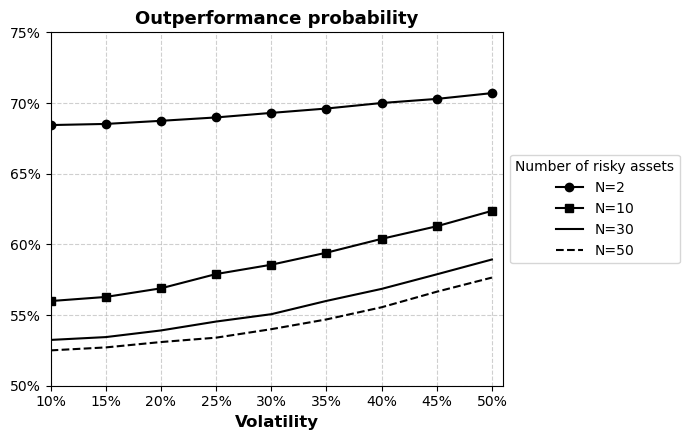

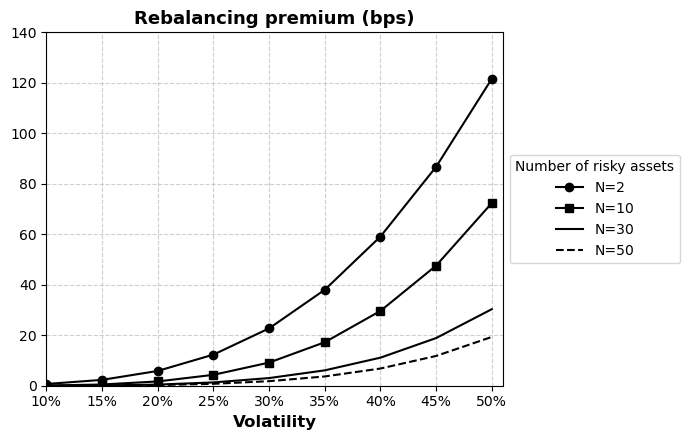

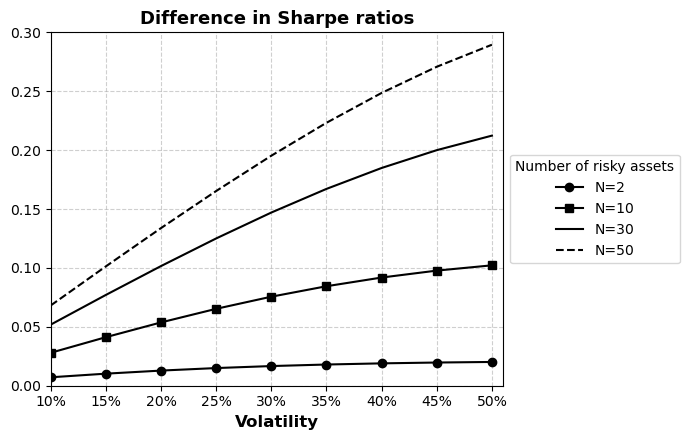

In [35]:
# Convert to numpy arrays
sig_values = np.array(sig_values)
N_values = np.array(N_values)

# Define style mapping for number of assets
style_map = {
    2:  {"linestyle": "-", "marker": "o"},  # round
    10: {"linestyle": "-", "marker": "s"},  # square
    30: {"linestyle": "-", "marker": None},  # no market
    50: {"linestyle": "--", "marker": None} # dashed, no marker
}

# Define label mapping
label_map = {
    2: "N=2",
    10: "N=10",
    30: "N=30",
    50: "N=50"
}

# 1. Outperformance probability 
plt.figure(figsize=(7,4.5))
for j, N_val in enumerate(N_values):
    style = style_map[N_val]
    plt.plot(sig_values*100, prob[:, j]*100,
             label=label_map[N_val], 
             color="black", linestyle=style["linestyle"], 
             marker=style["marker"], markersize=6, markevery=1)

plt.xlabel("Volatility", fontsize=12, fontweight="bold")
plt.title("Outperformance probability", fontsize=13, fontweight="bold")
plt.legend(title="Number of risky assets", loc="center left", bbox_to_anchor=(1, 0.5))
plt.grid(True, linestyle="--", alpha=0.6)
plt.gca().xaxis.set_major_formatter(PercentFormatter(xmax=100, decimals=0))
plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=100, decimals=0))
plt.xlim(10, 51)
plt.ylim(50, 75)
plt.xticks(np.arange(10, 55, 5))
plt.yticks(np.arange(50, 76, 5))
plt.tight_layout()
plt.show()

# 2. Rebalancing premium (bps) 
plt.figure(figsize=(7,4.5))
for j, N_val in enumerate(N_values):
    style = style_map[N_val]
    plt.plot(sig_values*100, reb[:, j],
             label=label_map[N_val], 
             color="black", linestyle=style["linestyle"], 
             marker=style["marker"], markersize=6, markevery=1)

plt.xlabel("Volatility", fontsize=12, fontweight="bold")
plt.title("Rebalancing premium (bps)", fontsize=13, fontweight="bold")
plt.legend(title="Number of risky assets", loc="center left", bbox_to_anchor=(1, 0.5))
plt.grid(True, linestyle="--", alpha=0.6)
plt.gca().xaxis.set_major_formatter(PercentFormatter(xmax=100, decimals=0))
plt.xlim(10, 51)
plt.ylim(0, 140)
plt.xticks(np.arange(10, 55, 5))
plt.yticks(np.arange(0, 145, 20))
plt.tight_layout()
plt.show()

# 3. Difference in Sharpe ratios
plt.figure(figsize=(7,4.5))
for j, N_val in enumerate(N_values):
    style = style_map[N_val]
    plt.plot(sig_values*100, dSR[:, j],
             label=label_map[N_val], 
             color="black", linestyle=style["linestyle"], 
             marker=style["marker"], markersize=6, markevery=1)

plt.xlabel("Volatility", fontsize=12, fontweight="bold")
plt.title("Difference in Sharpe ratios", fontsize=13, fontweight="bold")
plt.legend(title="Number of risky assets", loc="center left", bbox_to_anchor=(1, 0.5))
plt.grid(True, linestyle="--", alpha=0.6)
plt.gca().xaxis.set_major_formatter(PercentFormatter(xmax=100, decimals=0))
plt.xlim(10, 51)
plt.ylim(0.00, 0.30)  
plt.xticks(np.arange(10, 55, 5))
plt.yticks(np.arange(0.00, 0.35, 0.05))
plt.tight_layout()
plt.show()

## <font color='green'> 1.6. Two-dimensional robustness check with regard to volatility and rebalancing frequency </font>

In [36]:
# Define parameters
N = 30
mu = np.full(N, 0.10)
sig_values = [0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50]
corr = np.identity(N)
w = np.ones(N) / N
freq_values = [1, 3, 6, 12]
dt = 1 / 12
steps = 60

# Initialize arrays to store results
prob = np.zeros((len(sig_values), len(freq_values)))
reb = np.zeros((len(sig_values), len(freq_values)))
dSR = np.zeros((len(sig_values), len(freq_values)))

# Loop for robustness checks
for i, sig_val in enumerate(sig_values):
    for j, freq_val in enumerate(freq_values):
        _, i2, _, _ = NumAnalysis(mu, sig_val* np.ones(N), corr, w, freq_val, dt, steps, nsims, cube_snd)
        prob[i, j] = i2[0][0]
        reb[i, j] = i2[1][0]
        dSR[i, j] = i2[8][0]

In [37]:
# Outperformance probability for various levels of volatility and rebalancing frequency
prob

array([[0.5324, 0.5291, 0.5251, 0.5205],
       [0.5344, 0.5311, 0.5292, 0.5265],
       [0.5391, 0.5341, 0.5344, 0.5285],
       [0.5454, 0.5385, 0.541 , 0.5353],
       [0.5506, 0.5486, 0.549 , 0.5419],
       [0.56  , 0.5559, 0.5563, 0.5486],
       [0.5685, 0.5647, 0.5676, 0.5593],
       [0.5788, 0.5758, 0.5766, 0.5692],
       [0.5893, 0.5876, 0.5862, 0.5803]])

In [38]:
# Rebalancing premium or various levels of volatility and rebalancing frequency
reb

array([[-8.80649344e-03, -2.77872588e-02,  2.57903262e-02,
         2.52604443e-02],
       [ 8.92986844e-02,  4.39517047e-02,  1.56294772e-01,
         1.48362532e-01],
       [ 4.46310528e-01,  3.58356604e-01,  5.39478483e-01,
         5.05099869e-01],
       [ 1.30953662e+00,  1.15647788e+00,  1.40402812e+00,
         1.30514523e+00],
       [ 3.03172033e+00,  2.78273931e+00,  3.07872127e+00,
         2.85091472e+00],
       [ 6.09228956e+00,  5.70612890e+00,  6.01342081e+00,
         5.55777533e+00],
       [ 1.11159274e+01,  1.05386983e+01,  1.07973339e+01,
         9.97135617e+00],
       [ 1.88823914e+01,  1.80452974e+01,  1.81684626e+01,
         1.67759058e+01],
       [ 3.03227680e+01,  2.91397307e+01,  2.90094354e+01,
         2.67889098e+01]])

In [39]:
# Sharpe ratio difference for various levels of volatility and rebalancing frequency
dSR

array([[0.05187066, 0.05009529, 0.04806078, 0.04302787],
       [0.07708227, 0.07439929, 0.07122651, 0.06367617],
       [0.10158548, 0.09799801, 0.09368169, 0.08363474],
       [0.12503436, 0.1205459 , 0.11508192, 0.10256462],
       [0.14701797, 0.14163245, 0.13501789, 0.1200625 ],
       [0.1670935 , 0.16081522, 0.1530485 , 0.13569393],
       [0.18484907, 0.17768279, 0.16876375, 0.14905638],
       [0.19997466, 0.19192552, 0.18185558, 0.15985021],
       [0.21231212, 0.20338572, 0.19216802, 0.16792887]])

### <font color='dodgerblue'> 1.6.1. Figure 5 </font> 

We reproduce below the three charts of Figure 5. The versions presented in the paper were originally generated with Excel.

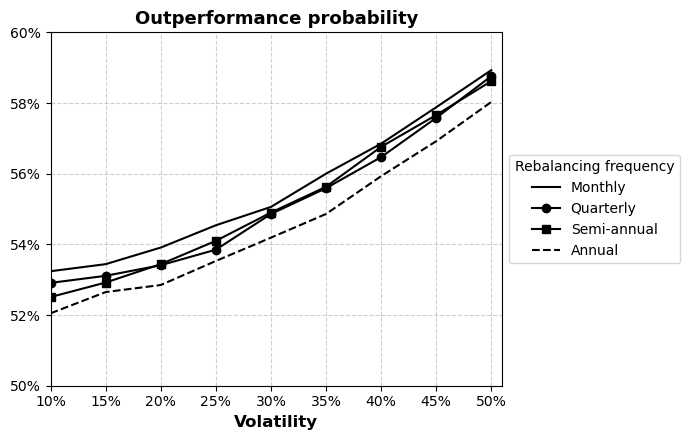

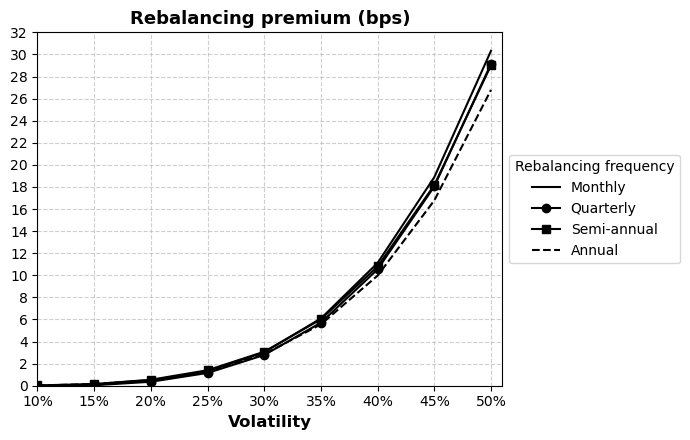

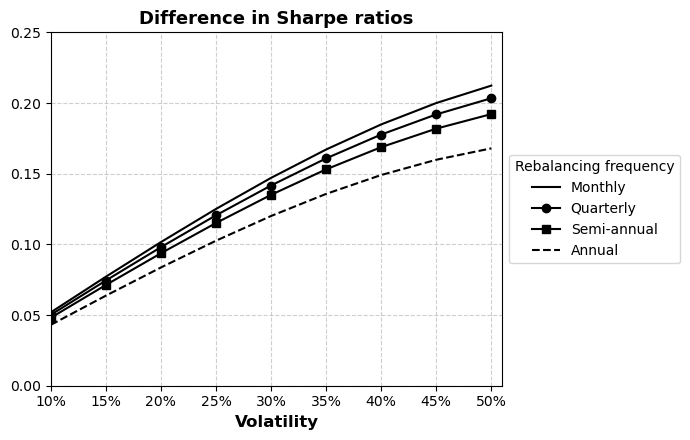

In [40]:
# Convert to numpy arrays
sig_values = np.array(sig_values)
freq_values = np.array(freq_values)

# Define style mapping for frequencies
style_map = {
    1:  {"linestyle": "-", "marker": None},   # no marker
    3:  {"linestyle": "-", "marker": "o"},   # circle
    6:  {"linestyle": "-", "marker": "s"},   # square
    12: {"linestyle": "--", "marker": None}  # dashed, no marker
}

# Define label mapping
label_map = {
    1: "Monthly",
    3: "Quarterly",
    6: "Semi-annual",
    12: "Annual"
}

# 1. Outperformance probability 
plt.figure(figsize=(7,4.5))
for j, f_val in enumerate(freq_values):
    style = style_map[f_val]
    plt.plot(sig_values*100, prob[:, j]*100,
             label=label_map[f_val], 
             color="black", linestyle=style["linestyle"], 
             marker=style["marker"], markersize=6, markevery=1)

plt.xlabel("Volatility", fontsize=12, fontweight="bold")
plt.title("Outperformance probability", fontsize=13, fontweight="bold")
plt.legend(title="Rebalancing frequency", loc="center left", bbox_to_anchor=(1, 0.5))
plt.grid(True, linestyle="--", alpha=0.6)
plt.gca().xaxis.set_major_formatter(PercentFormatter(xmax=100, decimals=0))
plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=100, decimals=0))
plt.xlim(10, 51)
plt.ylim(50, 60)
plt.xticks(np.arange(10, 55, 5))
plt.yticks(np.arange(50, 61, 2))
plt.tight_layout()
plt.show()

# 2. Rebalancing premium (bps)
plt.figure(figsize=(7,4.5))
for j, f_val in enumerate(freq_values):
    style = style_map[f_val]
    plt.plot(sig_values*100, reb[:, j],
             label=label_map[f_val], 
             color="black", linestyle=style["linestyle"], 
             marker=style["marker"], markersize=6, markevery=1)

plt.xlabel("Volatility", fontsize=12, fontweight="bold")
plt.title("Rebalancing premium (bps)", fontsize=13, fontweight="bold")
plt.legend(title="Rebalancing frequency", loc="center left", bbox_to_anchor=(1, 0.5))
plt.grid(True, linestyle="--", alpha=0.6)
plt.gca().xaxis.set_major_formatter(PercentFormatter(xmax=100, decimals=0))
plt.xlim(10, 51)
plt.ylim(0, 32)
plt.xticks(np.arange(10, 55, 5))
plt.yticks(np.arange(0, 33, 2))
plt.tight_layout()
plt.show()

# 3. Difference in Sharpe ratios 
plt.figure(figsize=(7,4.5))
for j, f_val in enumerate(freq_values):
    style = style_map[f_val]
    plt.plot(sig_values*100, dSR[:, j],
             label=label_map[f_val], 
             color="black", linestyle=style["linestyle"], 
             marker=style["marker"], markersize=6, markevery=1)

plt.xlabel("Volatility", fontsize=12, fontweight="bold")
plt.title("Difference in Sharpe ratios", fontsize=13, fontweight="bold")
plt.legend(title="Rebalancing frequency", loc="center left", bbox_to_anchor=(1, 0.5))
plt.grid(True, linestyle="--", alpha=0.6)
plt.gca().xaxis.set_major_formatter(PercentFormatter(xmax=100, decimals=0))
plt.xlim(10, 51)
plt.ylim(0.00, 0.25)  
plt.xticks(np.arange(10, 55, 5))
plt.yticks(np.arange(0.00, 0.30, 0.05))
plt.tight_layout()
plt.show()

# <font color='red'> 2. Numerical Analysis with Serial Correlation in Asset Returns </font>

Before running the Monte Carlo simulations, we start by plotting Figure 6 from the paper, which plots the autocorrelation at lag $k$ of the first difference of fractional Brownian motion as a function of the Hurst exponent $H$.

## <font color='green'> 2.1. Figure 6 </font>

We reproduce below the three charts of Figure 6. The version presented in the paper was originally generated with Matlab.

In [41]:
# Autocorrelation at lag k the function
def f(H, k):
    return 0.5 * ((k+1)**(2*H) - 2*(k**(2*H)) + (k-1)**(2*H))

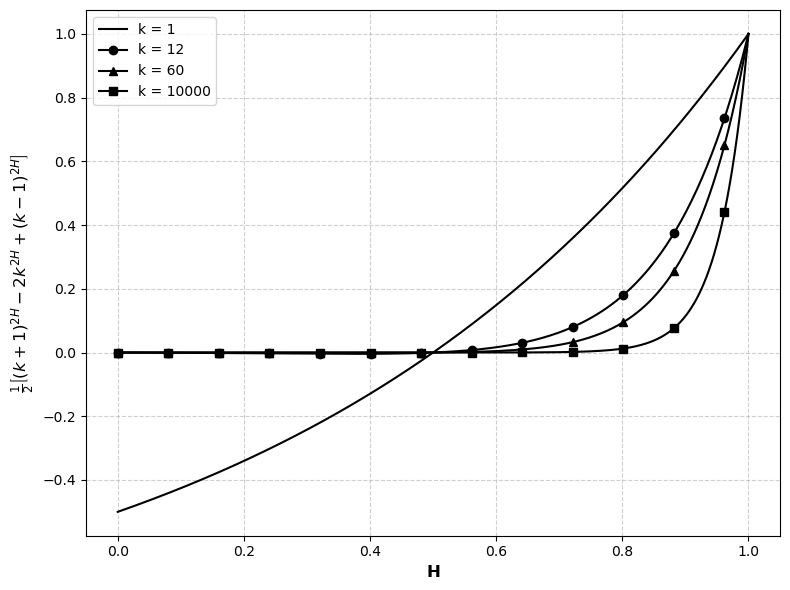

In [42]:
# Values of H (strictly positive, between 0 and 1)
H = np.linspace(1e-6, 1, 500)

# Values of k
k_values = [1, 12, 60, 10000]
markers = [None, 'o', '^', 's']  # None for k=1, then circle, triangle, square

# Plot
plt.figure(figsize=(8,6))
for k, m in zip(k_values, markers):
    if m is None:
        plt.plot(H, f(H, k), color='black', label=f'k = {k}')
    else:
        plt.plot(H, f(H, k), color='black', marker=m, markevery=40, label=f'k = {k}')

# Style
plt.xlabel('H', fontsize=12, fontweight = 'bold')
plt.ylabel(r'$\frac{1}{2}\left[(k+1)^{2H} - 2k^{2H} + (k-1)^{2H}\right]$', fontsize=12, fontweight = 'bold')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

## <font color='green'> 2.2. Figure 7 </font>

In [43]:
import random

np.random.seed(123)  # set the seed for reproducibility

steps = 1200
H_list = [0.3, 0.4, 0.6, 0.7]
fgn_sample=np.empty(shape=(steps,nsims,len(H_list)))

# Generate 10000 fractional Gaussian noises realizations for each of H values 
for count, H in enumerate(H_list):    
    for i in range(nsims):
        random.seed(i)
        fgn_sample[:,i,count] = fgn(n=steps, hurst=H, length=100, method='daviesharte')

In [44]:
# Dictionary of 3D-cubes following fractional Gaussian noises with H = 0.3, 0.4, 0.6 and 0.7
thisdict = {
  '0.3': fgn_sample[:,:,0].reshape((steps,nsims,1)),
  '0.4': fgn_sample[:,:,1].reshape((steps,nsims,1)),
  '0.6': fgn_sample[:,:,2].reshape((steps,nsims,1)),
  '0.7': fgn_sample[:,:,3].reshape((steps,nsims,1)),
  '0.5': cube_snd
}

In [45]:
# Function to calculate all the relevant analytics for the numerical analysis
# the rebalancing premium with serial correlation in asset returns

# Inputs: 
# mu: expected return vector
# sig: volatility vector
# corr: correlation matrix
# freq: rebalancing frequency in months
# dt: time step
# nsims: number of Monte Carlo simulations
# H: Hurst exponent

# Outputs: analytics of the rebalanced and buy-and-hold portfolios (tab), 
# vector with outperformance proba RP and dSR (rstats) and vector of the growth rate differences(dgrowth)

def NumAnalysis_SC(mu,sig,corr,w,freq,dt,steps,nsims,H):
    x = thisdict[str(H)]
    x = np.concatenate([x, np.zeros(shape=(x.shape[0],nsims,1))], -1)
    N = mu.shape[0] # number of assets
    S_0 = 100 * np.reshape(np.ones(N),(-1,1)) # initial (N*1) vector or prices at time t=0

    sigma = np.empty(shape=(N, N)) # covariance matrix
    
    for i in range(N):
        for j in range(N):
            sigma[i,j]=corr[i,j]*sig[i]*sig[j] # covariance matrix coefficients computation

    gstar=0.5*(sum(w*(sig*sig))-np.transpose(w)@ sigma @ w) # excess growth rate computation
    
    R = linalg.cholesky(corr) # Cholevsky factorisation: corr=R'*R where R is an upper triangular N*N matrix  
    S = np.empty(shape=(steps+1,nsims,N)) #initialisation of the steps+1 * nsims * N 3D-matrix of asset prices
 
    g = mu - sig*sig/2 #computation of the N*1 vector of expected growth rates
    
    # computation of the (steps+1)*N matrix of the stocks prices 
    for i in range(nsims):
        inter=x[0:steps,i,0:N]; #extract from the 3D-matrix of random numbers x a steps*Nassets matrix of random numbers 
        ep = inter @ R; # correlated steps*N random numbers sequences: each asset has its pairwise-correlated random sequence of length steps
        S[:,i,:] = np.concatenate((np.reshape(np.ones(N),(1,-1)),np.cumprod(np.exp(np.matlib.repmat(np.transpose(mu)*dt-np.transpose(sig*sig)/2*dt*2*H,steps,1)+ep@np.diagflat(sig)*np.sqrt(dt**(2*H))), axis = 0)), axis = 0)@np.diagflat(S_0)
    
    r = np.empty(shape=(steps,nsims,N)) # preallocation of steps*nsims*N 3D-matrix of assets returns

    for i in range(N):
        r[:,:,i] = S[1:,:,i]/S[:-1,:,i]-1;  # steps*nsims*N 3D-matrix of the assets returns

        
    w_REB=np.empty(shape=(steps+1,nsims,N)) #wREB(t,i,k) is, for the simulation i, the weight of asset k at time t-1(used for the computation of the portfolios' return at time t
    wtemp=np.empty(shape=(N,1)) #%preallocation
     
    for i in range(nsims): #%computation of the steps*nsims*N 3D-vector of weights of the rebalanced portfolios
         wtemp[:,0]=w # N*1 vector of weights initialisation
    
         for t in range(steps+1):
            if (t-1)%freq==0: # if t corresponds to a rebalancing date    
                wtemp[:,0]=w # Set the weights to the computed/naive weighs. Be careful if the (optimised) weighting scheme is time varying, the code has to be improved. It works in the case of weights independent of time at the rebalancing dates.
                w_REB[t,i,:]=wtemp[:,0] #loop for REB portfolio weights computation
            else: #if t is not a rebalancing date then the weights are drifting
                wtemp[:,0]=wtemp[:,0]*(1+np.squeeze(r[t-1,i,:])) # We use the equality of assets'shares between two consecutive dates. Squeeze allows to extract a 1D vector or 2D matrix from a 3D matrix by deleting singleton dimensions 
                wtemp[:,0]=wtemp[:,0]/np.sum(wtemp[:,0]) # (see "La Gestion d'Actifs Quantitative, Roncalli", P48 for the idea of the proof)
                w_REB[t,i,:]=wtemp[:,0] #loop for REB portfolio weights computation

    r_REB=np.empty(shape=(steps,nsims)) #preallocation

    for i in range(nsims):
        for t in range(steps):
            r_REB[t,i]=np.sum(np.squeeze(w_REB[t,i,:])*np.squeeze(r[t,i,:])) #loop for REB portfolio returns computation
    
    P_REB= 100*np.concatenate((np.reshape(np.ones(nsims),(1,-1)),np.cumprod(1+r_REB,axis=0)), axis = 0)
  
    S_BH=np.empty(shape=(steps+1,nsims,N))  #%preallocation
    for i in range(N):
        S_BH[:,:,i]= w[i]*S[:,:,i] #loop for B&H portfolio wealth computation

 
    P_BH=np.sum(S_BH,2) # (steps+1)*nsims matrix of B&H portfolio wealth computation
    r_BH=P_BH[1:,:]/P_BH[:-1,:]-1 # steps*nsims matrix of B&H portfolio  return computation

    w_BH=np.empty(shape=(steps+1,nsims,N))  #%preallocation
    ENCt_BH=np.empty(shape=(steps+1,nsims))

    for i in range(nsims):
        for j in range(steps+1):
            w_BH[j,i,:]=np.squeeze(S_BH[j,i,:])/np.sum(np.squeeze(S_BH[j,i,:])) #loop for B&H portfolio weights computation
            ENCt_BH[j,i]=pow(1/np.linalg.norm(np.squeeze(w_BH[j,i,:])),2) *1/N

    # Risk, Performance and Diversification Statistics computation
    mu_REB=1/dt*np.mean(np.mean(r_REB,0))
    mu_BH=1/dt*np.mean(np.mean(r_BH,0))
    vol_REB=np.sqrt(1/dt)*np.mean(np.std(r_REB, axis = 0, ddof=1))
    vol_BH=np.sqrt(1/dt)*np.mean(np.std(r_BH, axis = 0, ddof=1))
    SR_REB=(mu_REB-0.02)/vol_REB
    SR_BH=(mu_BH-0.02)/vol_BH
    skewness_REB=np.mean(skew(r_REB, axis = 0, bias=False)) #data frequency has no impact
    skewness_BH=np.mean(skew(r_BH, axis = 0, bias=False))
    kurtosis_REB=np.mean(kurtosis(r_REB, fisher = False, axis = 0, bias = True))
    kurtosis_BH=np.mean(kurtosis(r_BH, fisher = False, axis = 0, bias = True))
    MDDown_REB=-np.mean(Max_DD(r_REB))
    MDDown_BH=-np.mean(Max_DD(r_BH))
    var1_REB=np.mean(np.percentile(r_REB, 0.01 ,axis=0))
    var1_BH=np.mean(np.percentile(r_BH,0.01 ,axis=0))
    ENC_BH=np.mean(np.mean(ENCt_BH,0))

#Rebalancing Statistics computation
    Ratio=P_REB/P_BH #Wealth ratio between REB and B&H
    P=np.empty(shape=(steps+1,1))  #preallocation
    for i in range(steps+1):
        P[i]=np.sum(Ratio[i,:]>1)/Ratio[i,:].shape[0] #loop for outperformance probability computation. 

    dgrowthnonan=np.log(Ratio)
    dgrowth=1/(steps*dt)*dgrowthnonan[steps,:]
    dwealth=P_REB[steps,:]-P_BH[steps,:]
    RP=np.mean(dgrowth)

    dSR=SR_REB-SR_BH


#Turnover computation
    wtemp=np.empty(shape=(N,1)) #preallocation
    w_minus_REB=np.empty(shape=(steps,nsims,N)) #preallocation
    deltaw=np.empty(shape=(steps,nsims)) #preallocation
    for i in range(nsims):
        for t in range(freq-1,steps,freq): #consider each date before the month of a rebalancing date
            wtemp=w_REB[t,i,:]*(1+r[t,i,:])
            w_minus_REB[t,i,:]=wtemp/np.sum(wtemp) 
            deltaw[t,i]=np.sum(np.abs(np.squeeze(w_minus_REB[t,i,:])-w))

    nbreb=np.sum(~np.isnan(deltaw[:,1])) #number of rebalancing
    Turnover_REB=1/freq*12*0.5*np.nanmean(np.nanmean(deltaw,0),0)
    
    tab=np.empty(shape=(9,2))
    
    tab[0,0]=mu_REB
    tab[1,0]=vol_REB
    tab[2,0]=SR_REB
    tab[3,0]=skewness_REB
    tab[4,0]=kurtosis_REB
    tab[5,0]=MDDown_REB
    tab[6,0]=var1_REB
    tab[7,0]=1
    tab[8,0]=Turnover_REB
 
    tab[0,1]=mu_BH
    tab[1,1]=vol_BH
    tab[2,1]=SR_BH
    tab[3,1]=skewness_BH
    tab[4,1]=kurtosis_BH
    tab[5,1]=MDDown_BH
    tab[6,1]=var1_BH
    tab[7,1]=ENC_BH
    tab[8,1]=0
 
    rstats=np.empty(shape=(9,1))
    
    rstats[0]=P[steps]
    rstats[1]=RP*10000 # in bps
    rstats[2]=dSR
    rstats[3]=(RP - t_dist.ppf(0.975, nsims-1)*np.std(dgrowth,ddof = 1)/np.sqrt(nsims-1))*10000 #in bps
    rstats[4]=(RP + t_dist.ppf(0.975, nsims-1)*np.std(dgrowth,ddof = 1)/np.sqrt(nsims-1))*10000 #in bps
    rstats[5]=gstar
    rstats[6]=RP-gstar
    rstats[7]=np.mean(dgrowth[dgrowth>0])
    rstats[8]=np.mean(dgrowth[dgrowth<0])
    
    return tab, rstats, dgrowth, dwealth

In [46]:
# Define parameters
mu = np.array([0.10,0.02])
freq = 1
dt = 1 / 12
steps = 60
sig_values = [0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50] #Possible volatility values for the risky asset. Risk-free asset vol is 0.
H_values = [0.3, 0.4, 0.5, 0.6, 0.7]
corr = np.array([[1,0],[0,1]]) # Define the correlation matrix
w = 1/2*np.ones(2) # Define the portfolio weights


# Initialize arrays to store results
prob = np.zeros((len(sig_values), len(H_values)))
reb = np.zeros((len(sig_values), len(H_values)))
dSR = np.zeros((len(sig_values), len(H_values)))

# Loop for robustness checks
for i, sig_val in enumerate(sig_values):
    for j, H_val in enumerate(H_values):
        _, i2, _, _ = NumAnalysis_SC(mu, np.array([sig_val,0]), corr, w, freq, dt, steps, nsims, H_val)
        prob[i, j] = i2[0][0]
        reb[i, j] = i2[1][0]
        dSR[i, j] = i2[2][0]

/opt/anaconda3/envs/empirical-env/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/empirical-env/lib/python3.11/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


We reproduce below the three charts of Figure 7. The versions presented in the paper were originally generated with Excel.

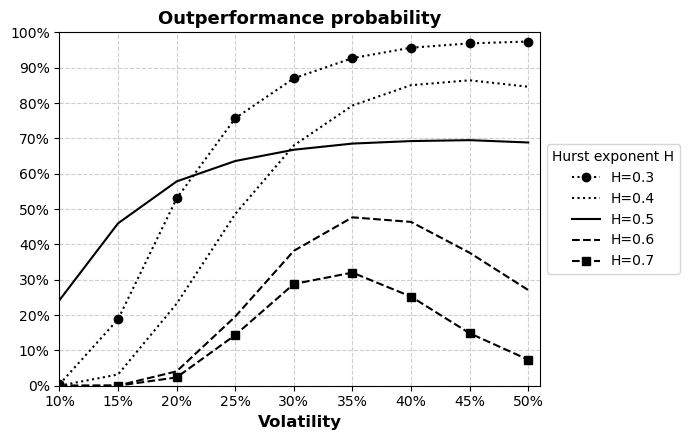

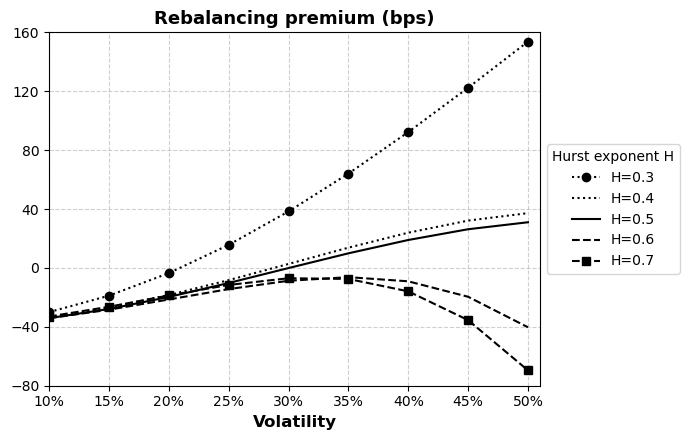

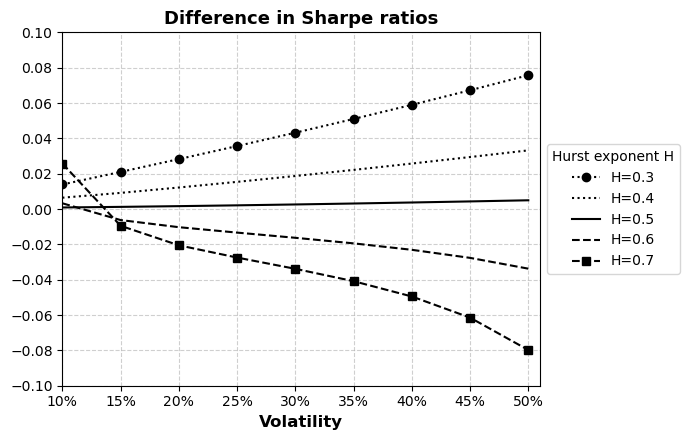

In [47]:
# Convert to numpy arrays
sig_values = np.array(sig_values)
H_values = np.array(H_values)

# Define style mapping for H values
style_map = {
    0.3: {"linestyle": ":", "marker": "o"},   # dotted, no marker
    0.4: {"linestyle": ":", "marker":None},            # dotted, no marker
    0.5: {"linestyle": "-", "marker": None},  # no marker
    0.6: {"linestyle": "--", "marker": None},   # dashed, no marker
    0.7: {"linestyle": "--", "marker": "s"}  # dashed, square
}

# Define label mapping
label_map = {H: f"H={H:.1f}" for H in H_values}

# 1. Outperformance probability 
plt.figure(figsize=(7,4.5))
for j, H_val in enumerate(H_values):
    style = style_map[H_val]
    plt.plot(sig_values*100, prob[:, j]*100,
             label=label_map[H_val], 
             color="black", linestyle=style["linestyle"], 
             marker=style["marker"], markersize=6, markevery=1)

plt.xlabel("Volatility", fontsize=12, fontweight="bold")
plt.title("Outperformance probability", fontsize=13, fontweight="bold")
plt.legend(title="Hurst exponent H", loc="center left", bbox_to_anchor=(1, 0.5))
plt.grid(True, linestyle="--", alpha=0.6)
plt.gca().xaxis.set_major_formatter(PercentFormatter(xmax=100, decimals=0))
plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=100, decimals=0))
plt.xlim(10, 51)
plt.ylim(0, 100)
plt.xticks(np.arange(10, 55, 5))
plt.yticks(np.arange(0, 101, 10))
plt.tight_layout()
plt.show()

# 2. Rebalancing premium (bps)
plt.figure(figsize=(7,4.5))
for j, H_val in enumerate(H_values):
    style = style_map[H_val]
    plt.plot(sig_values*100, reb[:, j],
             label=label_map[H_val], 
             color="black", linestyle=style["linestyle"], 
             marker=style["marker"], markersize=6, markevery=1)

plt.xlabel("Volatility", fontsize=12, fontweight="bold")
plt.title("Rebalancing premium (bps)", fontsize=13, fontweight="bold")
plt.legend(title="Hurst exponent H", loc="center left", bbox_to_anchor=(1, 0.5))
plt.grid(True, linestyle="--", alpha=0.6)
plt.gca().xaxis.set_major_formatter(PercentFormatter(xmax=100, decimals=0))
plt.xlim(10, 51)
plt.ylim(-80, 160)
plt.xticks(np.arange(10, 55, 5))
plt.yticks(np.arange(-80, 165, 40))
plt.tight_layout()
plt.show()

# 3. Difference in Sharpe ratios
plt.figure(figsize=(7,4.5))
for j, H_val in enumerate(H_values):
    style = style_map[H_val]
    plt.plot(sig_values*100, dSR[:, j],
             label=label_map[H_val], 
             color="black", linestyle=style["linestyle"], 
             marker=style["marker"], markersize=6, markevery=1)

plt.xlabel("Volatility", fontsize=12, fontweight="bold")
plt.title("Difference in Sharpe ratios", fontsize=13, fontweight="bold")
plt.legend(title="Hurst exponent H", loc="center left", bbox_to_anchor=(1, 0.5))
plt.grid(True, linestyle="--", alpha=0.6)
plt.gca().xaxis.set_major_formatter(PercentFormatter(xmax=100, decimals=0))
plt.xlim(10, 51)
plt.ylim(-0.10, 0.10)  
plt.xticks(np.arange(10, 55, 5))
plt.yticks(np.arange(-0.10, 0.12, 0.02))
plt.tight_layout()
plt.show()